In [23]:
## Setup and importing libraries.
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, module='.*/IPython/.*')

import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import datetime

%matplotlib inline

from IPython.display import Image
from IPython.display import display

import pyLDAvis
import pyLDAvis.sklearn

from sklearn.externals import joblib

pyLDAvis.enable_notebook()

In [24]:
import nltk
#nltk.download()
from nltk.corpus import stopwords

In [25]:
def getFrequences(df_data):
    """df_data is a collection of textual documents. 
    """
    import nltk
    from nltk.corpus import stopwords
    from sklearn.feature_extraction.text import CountVectorizer
    
    count_vect = CountVectorizer(stop_words=stopwords.words('italian')) #CountVectorizer supports counts of N-grams of words or consecutive characters.
    words_counts = count_vect.fit_transform(df_data)
   
    #Most frequent words (stopword removed)
    sum_words = words_counts.sum(axis=0) #sum for each column
    words_freq = [(word, sum_words[0, idx]) for word, idx in count_vect.vocabulary_.items()]
    return words_freq

def plotTopNWords(sorted_frequents_words, N, title):
    """frequents_words: list of frequents words. Type: tuple(str, numpy.int64)
       N: number of words to plot 
    """
    most_frequents_words = sorted(sorted_frequents_words, key = lambda x: x[1], reverse=True)
    x, y = zip(*most_frequents_words[1:20]) # unpack a list of pairs into two tuples

    fig = plt.figure()
    ax1 = fig.add_subplot(111)  # Create matplotlib axes
    ax1.set_title(title)
    ax1.plot(x, y)
    for tl in ax1.get_xticklabels():
        tl.set_rotation(90)

    file_name = 'imgs/top'+str(N)+'_words_plot.png'    
    plt.savefig(file_name) #png

    plt.clf
    return file_name

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()


In [4]:
file = "data/anac/anac_indicepa_2017.tsv"
df = pd.read_csv(file, sep="\t")

## Steps

1. Remove data with empty objects: From 1321761 rows to 1321651;
2. Preprocessing: tokenizing, remove of stopwords, stemming;
3. Tf-idf vectorization;
4. LDA (https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/);
5. Visualize topic distribution with [pyLDAvis](http://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/pyLDAvis_overview.ipynb#topic=8&lambda=0.62&term=)

### Remove empty elements from the corpus
There are ten documents with empty text

In [5]:
data = df["oggetto"]
print("Initial dataset size ",data.shape)
data = data.dropna()
print("Dataset size after removing empty elements: ",data.shape)

Initial dataset size  (1321761,)
Dataset size after removing empty elements:  (1321651,)


### Word frequences (tf, tf-idf)

Word counts are a good starting point, but are very basic. One issue with simple counts is that most frequent words are not very meaningful in the encoded vectors.

We define two alternative approaches:

- Term Frequency: This summarizes how often a given word appears within a document.
- Tf-idf: the term frequency is normalized with the *Inverse Document Frequency* which downscales words that appear a lot across documents.


Python provides three important object for calculating the word frequencies:
- *TfidfVectorizer*  tokenizes documents, learns the vocabulary and inverse document frequency weightings, and allows us to encode new documents. 
-  *CountVectorizer* provides a simple way to both tokenize a collection of text documents and build a vocabulary of known words. it returns an encoded vector with a length of the entire vocabulary and an integer count for the number of times each word appeared in the document.
- Alternately, if you already have a learned CountVectorizer, you can use it with a *TfidfTransformer* to just calculate the inverse document frequencies and start encoding documents.

In [6]:
# Counting word occurences
#There are 594151 unique terms. Only 1027 words have a frequency higher than 1%. 
#We remove from our analysis all italian stopwords 

from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.snowball import ItalianStemmer
from nltk.stem.snowball import SnowballStemmer


stemmer = ItalianStemmer()
analyzer = CountVectorizer().build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

count_vect = CountVectorizer(stop_words=stopwords.words('italian'), analyzer=stemmed_words, min_df=0.001) #CountVectorizer supports counts of N-grams of words or consecutive characters.

#count_vect = CountVectorizer(stop_words=stopwords.words('italian'),  min_df=0.001) #CountVectorizer supports counts of N-grams of words or consecutive characters.

words_counts = count_vect.fit_transform(data)
words_counts.shape

(1321651, 1027)

In [7]:
#Tf-idf
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer(use_idf=False).fit(words_counts)
tf_idf_matrix = tf_transformer.transform(words_counts)
tf_idf_matrix.shape

(1321651, 1027)

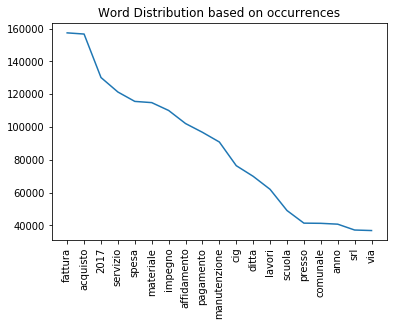

In [8]:
top_terms = 20
frequent_words = getFrequences(data)
dict_freq = dict(frequent_words)
file_name = plotTopNWords(frequent_words, top_terms, "Word Distribution based on occurrences")
#i = Image(file_name)
#display(i)

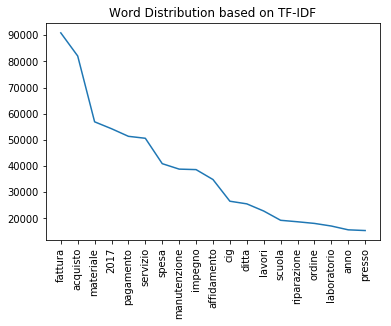

In [9]:
#Tf-Idf distribution
scores = zip(count_vect.get_feature_names(), np.asarray(tf_idf_matrix.sum(axis=0)).ravel())
sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
file_name = plotTopNWords(sorted_scores, top_terms,  "Word Distribution based on TF-IDF")

In [10]:
#Check term frequency 
word = u'riqualificazione'
freq = dict_freq.get(word)
rel_freq = freq / words_counts.shape[0]

print("word:", word)
print("absolute frequency:", freq)
print("relative frequency:", rel_freq)

word: riqualificazione
absolute frequency: 3818
relative frequency: 0.00288881104013


## Topic Discovering with Latent Dirichlet Allocation (LDA)

In natural language processing, latent Dirichlet allocation (LDA) is a generative statistical model used for discovering topics from texual corpora. The model assumes that every topic is a distribution of words in the vocabulary, and every document (described over the same vocabulary) is a distribution of a small subset of these topics. This is a statistical way to say that each topic (e.g. space) has some representative words (star, planet, etc.), and each document is only about a handful of these topics.
For example suppose you have the following set of sentences:

- I ate a banana and spinach smoothie for breakfast
- I like to eat broccoli and bananas.
- Chinchillas and kittens are cute.
- My sister adopted a kitten yesterday.
- Look at this cute hamster munching on a piece of broccoli.

We want clustering documents in 2 topics. LDA may cluster documents as follows:
- Sentences 1 and 2: 100% Topic A
- Sentences 3 and 4: 100% Topic B
- Sentence 5: 60% Topic A, 40% Topic B

and identify the following topics:
- Topic A: 30% broccoli, 15% bananas, 10% breakfast, 10% munching, ... (at which point, you could interpret topic A to be about food)
- Topic B: 20% chinchillas, 20% kittens, 20% cute, 15% hamster, ... (at which point, you could interpret topic B to be about cute animals)

As we can see from the above example LDA factorizes the input document-term matrix in two matrices:
- Document- Topic matrix;
- Topic-Term matrix.

![alt text](data/imgs/LDA_matrix_factorization.png "Logo Title Text 1")

LDA is generally used for qualitative understanding of big text corpora. In fact, the latent topics that the model learns are highly interpretable and provide deep insights to the data. 


LDA requires as input the number of topics *n_components*. Moreover we can control other paramethers such as:
- *learning_decay* which controls the learning rate;
- *learning_offset* which downweighs early iterations. Should be > 1
- *max_iter* a stop condition;

In [ ]:
# Define Search Param
search_params = {'n_topics': [5, 10, 15, 20], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

In [ ]:
#GridSearchCV(cv=None, error_score='raise',
#       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
#             evaluate_every=-1, learning_decay=0.7, learning_method=None,
#             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
#            mean_change_tol=0.001, n_components=10, n_jobs=1,
#             n_topics=None, perp_tol=0.1, random_state=None,
#             topic_word_prior=None, total_samples=1000000.0, verbose=0),
#       fit_params=None, iid=True, n_jobs=1,
#       param_grid = search_params,
#       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
#       scoring=None, verbose=0)

In [ ]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

joblib.dump(best_lda_model,'best_lda_model.pkl') 

In [ ]:
#n_components=10

##LDA Complexity O(Nd^2), where N is the number of examples and d is the feature dimension
#from sklearn.decomposition import NMF, LatentDirichletAllocation
#from time import time

#lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
#                                learning_method='online',
#                                learning_offset=50.,
#                                random_state=0)
#t0 = time()
#lda.fit(tf_idf_matrix)

#print("LDA model learned in %0.3fs." % (time() - t0))

#lda_output = lda.transform(tf_idf_matrix)

## Log Likelyhood: Higher the better
#print("Log Likelihood: ", lda.score(tf_idf_matrix))

## Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
#print("Perplexity: ", lda.perplexity(tf_idf_matrix))

## See model parameters
#print(lda.get_params())

## store model
#joblib.dump(lda,'lda_model.pkl') 

In [ ]:
print("\nTopics in LDA model:")
n_top_words = 5
tf_feature_names = count_vect.get_feature_names()
print_top_words(best_lda_model, tf_feature_names, n_top_words)

## Visualize topic model

In [11]:
lda = joblib.load('lda_model.pkl') 

In [12]:
#pyLDAvis.sklearn.prepare(lda, tf_idf_matrix, count_vect, mds='tsne')
pyLDAvis.sklearn.prepare(lda, tf_idf_matrix, count_vect)

/Users/fabiana/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
8      14.493344        1       1  0.096221 -0.018849
2      13.948388        1       2  0.137107  0.098987
4      13.139894        1       3  0.149022  0.223056
6       9.555349        1       4  0.024138  0.207392
7       9.282627        1       5  0.047193 -0.256632
0       8.544571        1       6  0.113783  0.085548
3       8.358736        1       7  0.045539 -0.244594
1       8.254711        1       8 -0.341580  0.066169
9       7.416288        1       9  0.083257 -0.162164
5       7.006092        1      10 -0.354682  0.001086, topic_info=     Category           Freq           Term          Total  loglift  logprob
term                                                                        
383   Default  126001.000000        fattura  126001.000000  30.0000  30.0000
66    Default  112407.000000       acquisto  112407.000000  29.0000  29.0000
552   Default   72797.000000      materiale   72797.000000  28.0000  28.0000
406   Default   68972.000000      fornitura   68972.000000  27.0000  27.0000
651   Default   65440.000000      pagamento   65440.000000  26.0000  26.0000
17    Default   51390.000000           2017   51390.000000  25.0000  25.0000
640   Default   27510.000000         ordine   27510.000000  24.0000  24.0000
892   Default   29267.000000          spesa   29267.000000  23.0000  23.0000
543   Default   35733.000000   manutenzione   35733.000000  22.0000  22.0000
452   Default   27870.000000        impegno   27870.000000  21.0000  21.0000
833   Default   30091.000000         scuola   30091.000000  20.0000  20.0000
724   Default   18877.000000       progetto   18877.000000  19.0000  19.0000
852   Default   23613.000000       servizio   23613.000000  18.0000  18.0000
614   Default   17200.000000       noleggio   17200.000000  17.0000  17.0000
797   Default   17380.000000    riparazione   17380.000000  16.0000  16.0000
270   Default   15204.000000          corso   15204.000000  15.0000  15.0000
491   Default   15219.000000    laboratorio   15219.000000  14.0000  14.0000
747   Default   14473.000000        pulizia   14473.000000  13.0000  13.0000
86    Default   14382.000000         alunni   14382.000000  12.0000  12.0000
380   Default   13265.000000           fatt   13265.000000  11.0000  11.0000
180   Default   13260.000000    cancelleria   13260.000000  10.0000  10.0000
815   Default   16348.000000          saldo   16348.000000   9.0000   9.0000
1011  Default   12480.000000        viaggio   12480.000000   8.0000   8.0000
731   Default   15533.000000           prot   15533.000000   7.0000   7.0000
893   Default   12374.000000          spese   12374.000000   6.0000   6.0000
96    Default   14586.000000           anno   14586.000000   5.0000   5.0000
405   Default   11331.000000     formazione   11331.000000   4.0000   4.0000
167   Default   14352.000000             bo   14352.000000   3.0000   3.0000
712   Default   12313.000000       primaria   12313.000000   2.0000   2.0000
251   Default   11640.000000        consumo   11640.000000   1.0000   1.0000
...       ...            ...            ...            ...      ...      ...
779   Topic10    4570.448986           rete    4571.440897   2.6582  -3.6903
821   Topic10    3861.738773      sanitario    3862.730625   2.6581  -3.8588
469   Topic10    3458.776848  installazione    3459.768744   2.6581  -3.9690
445   Topic10    3379.983987       igienico    3380.975840   2.6581  -3.9920
516   Topic10    2873.752456            lim    2874.744344   2.6580  -4.1543
424   Topic10    2576.908040         generi    2577.899919   2.6580  -4.2633
221   Topic10    2273.262951             cl    2274.254925   2.6580  -4.3887
871   Topic10    2237.221942       soccorso    2238.213826   2.6579  -4.4046
112   Topic10    2007.585586           argo    2008.577540   2.6579  -4.5129
267   Topic10    1991.515274          copie    1992.507156   2.6579  -4.521

## Visualize documents

Here we want to cluster each document basing on its dominant topic. To visualize documents in a 2D space we use TSNE. 

In [13]:
# Create Document - Topic Matrix
lda_output = lda.transform(tf_idf_matrix)

In [16]:
# column names
topicnames = ["Topic" + str(i) for i in range(lda.n_topics)]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topic.head(10).style.applymap(color_green).applymap(make_bold)

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
0,0.03,0.23,0.55,0.03,0.03,0.03,0.03,0.03,0.03,0.03,2
1,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.31,0.03,0.45,9
2,0.37,0.03,0.03,0.03,0.03,0.03,0.03,0.37,0.03,0.03,0
3,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.63,0.04,0.04,7
4,0.03,0.34,0.34,0.03,0.03,0.03,0.03,0.13,0.03,0.03,1
5,0.03,0.03,0.03,0.03,0.03,0.2,0.03,0.53,0.03,0.03,7
6,0.04,0.04,0.04,0.04,0.04,0.67,0.04,0.04,0.04,0.04,5
7,0.31,0.03,0.03,0.03,0.03,0.03,0.03,0.31,0.17,0.03,0
8,0.03,0.74,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,1
9,0.03,0.2,0.19,0.03,0.03,0.26,0.03,0.19,0.03,0.03,5


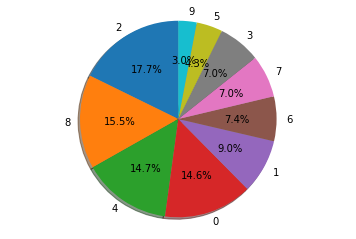

In [17]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
agg_topic_document = df_document_topic["dominant_topic"].value_counts()

fig1, ax1 = plt.subplots()
ax1.pie(agg_topic_document, labels=agg_topic_document.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [19]:
import plotly.offline as py
import plotly.plotly as py_on
import plotly.graph_objs as go
from plotly import tools
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)

from IPython.display import Image
from IPython.display import display

from sklearn.manifold import TSNE

tsne_labels = df_document_topic["dominant_topic"]

#tsne = TSNE(n_components=2, verbose=1, perplexity=4, n_iter=1500)
tsne = TSNE(n_components=2, verbose=1, n_iter=250)
tsne_results = tsne.fit_transform(tf_idf_matrix[1:100].toarray())

df_tsne = pd.DataFrame(tsne_results)

scatter = [go.Scatter(
    name = "TSNE",
    x=df_tsne[0],
    y=df_tsne[1],
    text=df["oggetto"],
    mode='markers',
    marker=dict(
        size=4,
        color=tsne_labels,
        line=dict(
            color=tsne_labels,
            width=1
        )#,opacity=0.8
    )
)]

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 99 samples in 0.001s...
[t-SNE] Computed neighbors for 99 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 99 / 99
[t-SNE] Mean sigma: 0.465782
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.125229
[t-SNE] Error after 251 iterations: 179769313486231570814527423731704356798070567525844996598917476803157260780028538760589558632766878171540458953514382464234321326889464182768467546703537516986049910576551282076245490090389328944075868508455133942304583236903222948165808559332123348274797826204144723168738177180919299881250404026184124858368.000000


In [22]:
fig = go.Figure(data=scatter)
py.iplot(fig)